# Preparation

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from datetime import datetime

# Load Data

In [16]:
import pathlib
import kagglehub

# Download latest version
# data_dir = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")

# dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
# data_dir = pathlib.Path(data_dir)

In [17]:
data_dir="C:/Users/kuhak/.keras/datasets/rawanaman/"
data_dir=pathlib.Path(data_dir)
print(data_dir)

C:\Users\kuhak\.keras\datasets\rawanaman


In [18]:
# data_val_dir="C:/Users/kuhak/.keras/datasets/downloaded_images/"
# data_val_dir=pathlib.Path(data_val_dir)
# print(data_val_dir)

In [19]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

18160


In [20]:
# image_count = len(list(data_val_dir.glob('*/*.jpg')))
# print(image_count)

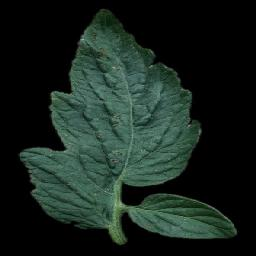

In [21]:
roses = list(data_dir.glob('Bacterial Spot/*'))
PIL.Image.open(str(roses[0]))

# Buat kumpulan data

In [22]:
batch_size = 32
img_height = 180
img_width = 180

In [23]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 18160 files belonging to 10 classes.
Using 14528 files for training.


In [24]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 18160 files belonging to 10 classes.
Using 3632 files for validation.


In [25]:
class_names = train_ds.class_names
print(class_names)

['Bacterial Spot', 'Early Blight', 'Healthy', 'Late Blight', 'Leaf Mold', 'Mosaic Virus', 'Septoria Leaf Spot', 'Spider Mites', 'Target Spot', 'Yellow Leaf Curl Virus']


# Visualisasi Data

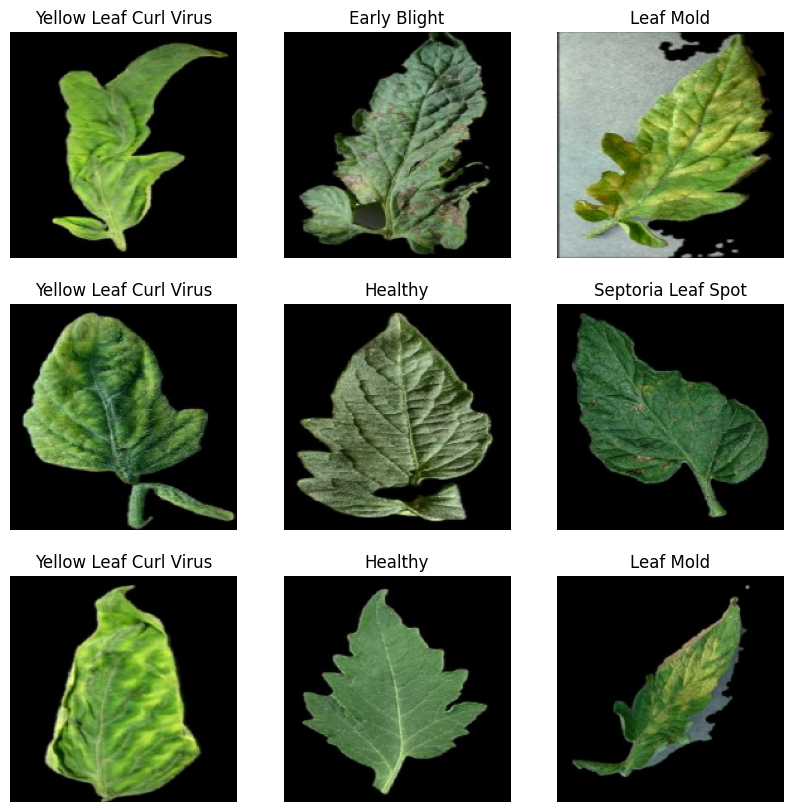

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Buat Modelnya

# Konfigurasikan kumpulan data untuk kinerja 

In [27]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Normalisasi

In [28]:
normalization_layer = layers.Rescaling(1./255)

In [29]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.855704


# Augmentasi

In [30]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

d:\Project Kuliah\uts\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


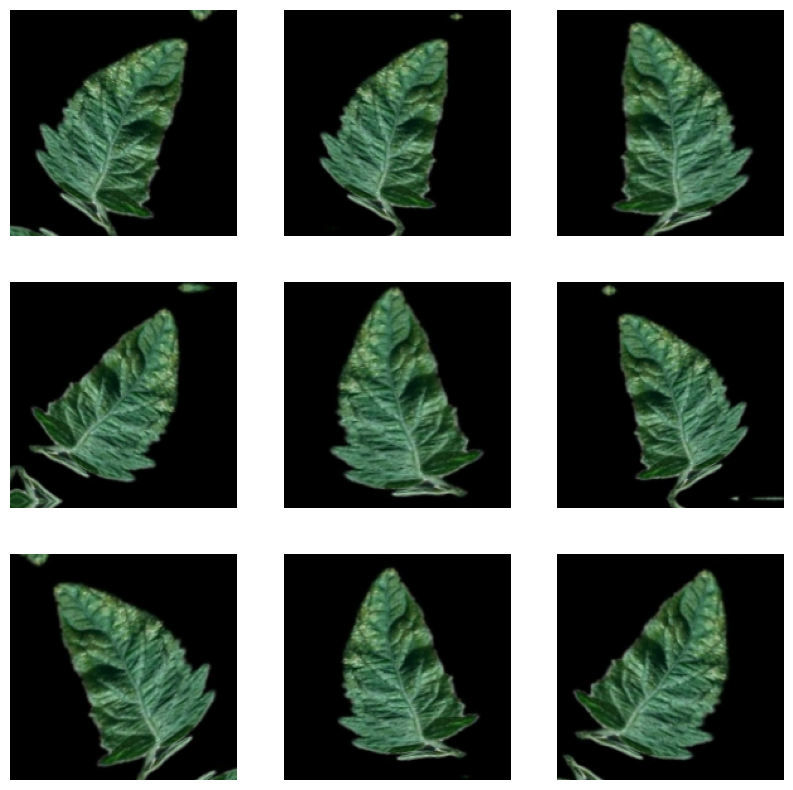

In [31]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [32]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [33]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,965,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,989,930 (15.22 MB)

 Trainable params: 3,989,930 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

# Training  

In [35]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

start_time = datetime.now()
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping]
)
end_time = datetime.now()

duration = end_time - start_time
print(f"Training duration: {duration}")

Epoch 1/10
454/454 ━━━━━━━━━━━━━━━━━━━━ 41s 86ms/step - accuracy: 0.5696 - loss: 1.2731 - val_accuracy: 0.7836 - val_loss: 0.5973
Epoch 2/10
454/454 ━━━━━━━━━━━━━━━━━━━━ 44s 97ms/step - accuracy: 0.8492 - loss: 0.4441 - val_accuracy: 0.8464 - val_loss: 0.4554
Epoch 3/10
454/454 ━━━━━━━━━━━━━━━━━━━━ 34s 75ms/step - accuracy: 0.9100 - loss: 0.2685 - val_accuracy: 0.8549 - val_loss: 0.4475
Epoch 4/10
454/454 ━━━━━━━━━━━━━━━━━━━━ 34s 75ms/step - accuracy: 0.9347 - loss: 0.1946 - val_accuracy: 0.8183 - val_loss: 0.6062
Epoch 5/10
454/454 ━━━━━━━━━━━━━━━━━━━━ 34s 74ms/step - accuracy: 0.9539 - loss: 0.1352 - val_accuracy: 0.8318 - val_loss: 0.5907
Epoch 6/10
454/454 ━━━━━━━━━━━━━━━━━━━━ 34s 75ms/step - accuracy: 0.9715 - loss: 0.0908 - val_accuracy: 0.8480 - val_loss: 0.6218
Epoch 7/10
454/454 ━━━━━━━━━━━━━━━━━━━━ 34s 74ms/step - accuracy: 0.9756 - loss: 0.0712 - val_accuracy: 0.8656 - val_loss: 0.5300
Epoch 8/10
454/454 ━━━━━━━━━━━━━━━━━━━━ 34s 74ms/step - accuracy: 0.9837 - loss: 0.0476 - 

In [36]:
# test_loss, test_acc = model.evaluate(X_test, y_test)
# print(f'Test accuracy: {test_acc:.2f}, Test loss: {test_loss:.2f}')

ValueError: x and y must have same first dimension, but have shapes (10,) and (8,)

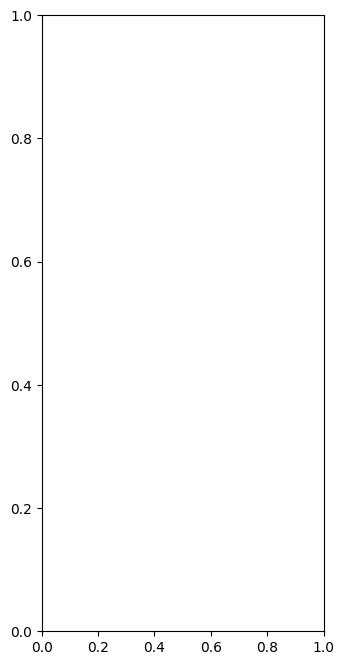

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Prediksi

In [ ]:
# sunflower_url = "https://th.bing.com/th/id/R.a7e5c81a4abfb3aee1481f7403e590b9?rik=dM75VVAjOpjLiA&riu=http%3a%2f%2fwww.thedailygarden.us%2fuploads%2f4%2f5%2f4%2f9%2f45493619%2f8226402877-38b85d3ed4-o_orig.jpg&ehk=rHfHALoZOfPajnakMbs%2b%2f1JP9%2bo4kbeQoTe8ldd9R84%3d&risl=&pid=ImgRaw&r=0"
# sunflower_path = tf.keras.utils.get_file('Yellow1', origin=sunflower_url)

# img = tf.keras.utils.load_img(
#     sunflower_path, target_size=(img_height, img_width)
# )
# img_array = tf.keras.utils.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0) # Create a batch

# predictions = model.predict(img_array)
# score = tf.nn.softmax(predictions[0])

# print(
#     "This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format(class_names[np.argmax(score)], 100 * np.max(score))
# )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
This image most likely belongs to Tomato___Late_blight with a 99.98 percent confidence.


# Saved Model

In [38]:
model.save('../rawanaman-ml/rwn-epc10v2.keras')

In [ ]:
# # Convert the model to TFLite format
# models = tf.keras.models.load_model('../rawanaman-ml/rwn-epc10.keras')

# converter = tf.lite.TFLiteConverter.from_keras_model(models)

# # Optionally, you can optimize the model for size and performance
# # converter.optimizations = [tf.lite.Optimize.DEFAULT]

# # Convert the model
# tflite_model = converter.convert()

# # Save the TFLite model to a file
# with open('rwn-epc10.tflite', 'wb') as f:
#     f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\kuhak\AppData\Local\Temp\tmp8w5dky7r\assets


INFO:tensorflow:Assets written to: C:\Users\kuhak\AppData\Local\Temp\tmp8w5dky7r\assets


Saved artifact at 'C:\Users\kuhak\AppData\Local\Temp\tmp8w5dky7r'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  1925201640720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1925201627856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1925201629776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1925201641104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1925201640144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1925201635344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1925189508880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1925189511376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1925189516176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1925199944720: TensorSpec(shape=(), dtype=tf.resource, name=None)
